In [2]:
import iris
import numpy as np
from iris.coords import DimCoord
from iris.coord_systems import TransverseMercator,GeogCS
from iris.cube import Cube
from cf_units import Unit
import cf_units
import os
import glob
from pyproj import Proj, transform
import sys
import warnings
import multiprocessing as mp
import cartopy.crs as ccrs

warnings.filterwarnings("ignore")

ems_hourly = ['01', '04', '06', '07', '08', '09', '10', '11', '12', '13', '15']
ems_30mins = ['bc005', 'bc006', 'bc007', 'bc009', 'bc010', 'bc011', 'bc013',  'bc015',  'bc016', 'bc017', 'bc018', 'bc012']
yrs_range = '1980_2001'

In [27]:
##########################################################################################
#########################################################################################
# Define variables and set up environment
##########################################################################################
##########################################################################################
root_fp = "/nfs/a319/gy17m2a/"
os.chdir(root_fp)

# Create path to files containing functions
sys.path.insert(0, root_fp + 'PhD/Scripts/DataProcessing/Regridding')
from Regridding_functions import *
# Create path to files containing functions
sys.path.insert(0, root_fp + 'Scripts/GlobalFunctions')
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *

gb_gdf = create_gb_outline({'init' :'epsg:3857'})

# Load UKCP18 12km model data to use in regriddding
file_model_12km=f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/12km/01/{yrs_range}/pr_rcp85_land-rcm_uk_12km_01_day_19801201-19901130.nc'
cube_12km=iris.load_cube(file_model_12km)

file_model_2_2km ='/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/2.2km/01/1980_2001/pr_rcp85_land-cpm_uk_2.2km_01_1hr_19910601-19910630.nc'
cube_2km =iris.load_cube(file_model_2_2km)

# remove ensemble member dimension
cube_2km = cube_2km[0,:,:,:]
cube_12km = cube_12km[0,:,:,:]

In [4]:
##################################################################
# This is a square area surrounding Leeds
leeds_at_centre_gdf = create_leeds_at_centre_outline({'init' :'epsg:3857'})
cube_12km_trimmed_to_leeds =  trim_to_bbox_of_region_obs(cube_12km, leeds_at_centre_gdf)

In [5]:
yrs_range = '1980_2001'
# ems_hourly = ['04', '06', '07', '08', '09', '10', ]

### Check plotting

In [57]:
# fig, ax= plt.subplots()
# iplt.contourf(cube_12km[1,:,:])
# plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);
# fig, ax= plt.subplots()
# iplt.contourf(cube_2km[1,:,:])
# plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

### Inspect coordinates

In [7]:
### 2km cube has grid_latitude and grid_longitude as 1D dimension coordinates (rotated geodesic)
### 2km cube has projection_y_coordinate and projection_x_coordinate as 1D dimension coordinates (BNG)

In [8]:
# cube_2km_test = cube_2km[0,1:5,:,:]
# cube_12km_test = cube_12km[0,1:5,:,:]
# iris.save(cube_12km_test,"mytest2km.nc")
# iris.save(cube_2km_test,"myest12km.nc")

In [9]:
# print(cube_2km.coord('grid_latitude').shape)
# print(cube_2km.coord('grid_longitude').shape)
# print(cube_12km.coord('projection_y_coordinate').shape)
# print(cube_12km.coord('projection_x_coordinate').shape)

In [10]:
### 2km cube has latitude and longitude as 2D dimension coordinates (rotated geodesic)
### 12km cube has grid_latitude and grid_longitude as 2D dimension coordinates (BNG)

In [11]:
# print(cube_2km.coord('latitude').shape)
# print(cube_2km.coord('longitude').shape)
# print(cube_12km.coord('grid_latitude').shape)
# print(cube_12km.coord('grid_longitude').shape)

In [12]:
### But are the grid_latitude and grid_longitude coordinates the same?
### Don't think so
### 2km is in rotated pole
### But 12km is in WGS84 still

In [13]:
# cube_12km.coord('grid_latitude').coord_system

# print(cube_2km.coord('grid_longitude').coord_system)
# print(cube_2km.coord('longitude').coord_system)

# print(cube_12km.coord('projection_y_coordinate').coord_system)
# print(cube_12km.coord('grid_longitude').coord_system)

## Transform cube 12km to WGS84

In [41]:
# this is the crs that we want to transform to
source_crs_12km = ccrs.OSGB(approx=False)
# these are the crs we are transforming from
target_crs = ccrs.Geodetic()

In [42]:
def convert_to_wgs84(source_crs, cube, x_coord_name, y_coord_name):
    # Extract the 2D meshgrid of X (eastings) and Y (northings) coordinates from the cube
    x = cube.coord(x_coord_name).points
    y = cube.coord(y_coord_name).points
    xx, yy = np.meshgrid(x, y)

    # Also get time for the new cube
    time_coord = cube.coord('time')

    # Use transform_points to project your coordinates
    transformed_points = target_crs.transform_points(source_crs, xx.flatten(), yy.flatten())

    # transformed_points now has a shape (n*m, 3), where the last dimension contains (lon, lat, z)
    # Reshape the array back to your original grid shape and separate the components
    lons, lats = transformed_points[..., 0].reshape(xx.shape), transformed_points[..., 1].reshape(yy.shape)

    # Now, you should create a new cube with these lons and lats as coordinates.
    # Note: This step requires careful handling to ensure the new cube's data aligns correctly with the transformed coordinates.
    # You might need to create new latitude and longitude DimCoords, ensuring they have bounds set if performing area-weighted regridding later.

    # Here's a simplified way to create a new cube with the transformed coordinates,
    # assuming your original data is 2-dimensional and compatible with the new grid.
    new_cube_data = cube.data  # This might require adjustment if the data needs to be interpolated onto the new grid.
    latitude_coord = iris.coords.DimCoord(lats[:, 0], standard_name='latitude', units='degrees')
    longitude_coord = iris.coords.DimCoord(lons[0, :], standard_name='longitude', units='degrees')

    # Guess bounds
    latitude_coord.guess_bounds()
    longitude_coord.guess_bounds()

    cube_wgs84 = iris.cube.Cube(new_cube_data,
                              dim_coords_and_dims=[(time_coord, 0), (latitude_coord, 1), (longitude_coord, 2)],
                              standard_name=cube.standard_name,
                              units=cube.units)
    
    return cube_wgs84

    
    

In [56]:
for em in ['04', '05', '06', '07', '08', '09', '10', '11', '12', '13','14','15']:
    print(em)
    os.chdir(f"/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/12km/{em}/{yrs_range}/")
    output_fp = f"/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/12km_wgs84/{em}/{yrs_range}/"
    if not os.path.isdir(output_fp):
        os.makedirs(output_fp)
    for filename in glob.glob("*"):    
        if os.path.isfile(output_fp +  f"wgs84_{filename}"):
            print("already exist")
        else:
            print(filename)
            cube = iris.load(filename)[0]
            # transform to wgs84
            transformed_cube_12km = convert_to_wgs84 (source_crs_12km, cube_12km,'projection_x_coordinate', 'projection_y_coordinate')
            # Save 
            iris.save(transformed_cube_12km, output_fp +  f"wgs84_{filename}")     

04
pr_rcp85_land-rcm_uk_12km_04_day_20501201-20601130.nc
pr_rcp85_land-rcm_uk_12km_04_day_19901201-20001130.nc
pr_rcp85_land-rcm_uk_12km_04_day_20601201-20701130.nc
pr_rcp85_land-rcm_uk_12km_04_day_20301201-20401130.nc
pr_rcp85_land-rcm_uk_12km_04_day_20401201-20501130.nc
pr_rcp85_land-rcm_uk_12km_04_day_20101201-20201130.nc
pr_rcp85_land-rcm_uk_12km_04_day_19801201-19901130.nc
pr_rcp85_land-rcm_uk_12km_04_day_20201201-20301130.nc
pr_rcp85_land-rcm_uk_12km_04_day_20001201-20101130.nc
pr_rcp85_land-rcm_uk_12km_04_day_20701201-20801130.nc
05
pr_rcp85_land-rcm_uk_12km_05_day_20001201-20101130.nc
pr_rcp85_land-rcm_uk_12km_05_day_20701201-20801130.nc
pr_rcp85_land-rcm_uk_12km_05_day_19901201-20001130.nc
pr_rcp85_land-rcm_uk_12km_05_day_20301201-20401130.nc
pr_rcp85_land-rcm_uk_12km_05_day_20101201-20201130.nc
pr_rcp85_land-rcm_uk_12km_05_day_20201201-20301130.nc
pr_rcp85_land-rcm_uk_12km_05_day_20601201-20701130.nc
pr_rcp85_land-rcm_uk_12km_05_day_20501201-20601130.nc
pr_rcp85_land-rcm_uk_1

FileNotFoundError: [Errno 2] No such file or directory: '/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/12km/14/1980_2001/'

In [45]:
cube_12km_wgs84 = convert_to_wgs84 (source_crs_12km, cube_12km,'projection_x_coordinate', 'projection_y_coordinate')
cube_2km_wgs84 = convert_to_wgs84 (source_crs_2km, cube_2km, "grid_longitude", "grid_latitude")

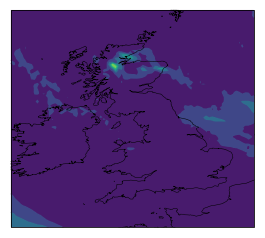

In [46]:
iplt.contourf(cube_12km_wgs84[1,:,:])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);